# Library

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

#EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#전처리
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectPercentile

#하이퍼파라미터 튜닝
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

#모델링
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier 

#평가 지표
from sklearn.metrics import roc_auc_score

#앙상블
from itertools import combinations
from scipy.stats import gmean
from vecstack import stacking

In [2]:
stf = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)

# 경로 설정 (Define your path)

In [3]:
path = 'open data/'

In [4]:
import os
os.listdir(path)

['sample_submission.csv', 'test_x.csv', 'train.csv']

# 데이터

In [5]:
import pandas as pd
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test_x.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

## 종속변수 변환

In [6]:
train.loc[train.voted==1,'voted']=0
train.loc[train.voted==2,'voted']=1

## 불필요한 컬럼 삭제

In [7]:
train = train.drop('index',axis=1)
test = test.drop('index',axis=1)

## 데이터 구조 확인 (Checking the shapes of data)

In [8]:
print(train.shape)
print(test.shape)
print(submission.shape)

(45532, 77)
(11383, 76)
(11383, 2)


## 데이터 통계 확인

In [9]:
train.describe()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,45532.000000,4.553200e+04,45532.000000,4.553200e+04,45532.000000,45532.000000,45532.000000,4.553200e+04,45532.000000,4.553200e+04,...,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,9.453570e+02,2.904463,2.189589e+03,3.662347,1484.294518,1.749078,1.490672e+03,2.317952,1.899292e+03,...,0.868708,0.895722,0.328538,0.938900,0.972195,0.202824,0.946104,0.395195,0.947729,0.927040
std,1.196952,1.307565e+04,1.566142,3.351027e+04,1.431494,8977.664318,1.043625,1.092260e+04,1.369205,1.670765e+04,...,0.337723,0.305625,0.469687,0.239516,0.164414,0.402107,0.225815,0.488898,0.222575,0.260073
min,1.000000,2.500000e+01,1.000000,2.500000e+01,1.000000,25.000000,1.000000,2.600000e+01,1.000000,2.500000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.040000e+02,1.000000,8.750000e+02,2.000000,651.000000,1.000000,6.790000e+02,1.000000,8.340000e+02,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,2.000000,5.570000e+02,3.000000,1.218000e+03,4.000000,899.000000,1.000000,9.310000e+02,2.000000,1.154000e+03,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,3.000000,8.270000e+02,4.000000,1.838000e+03,5.000000,1335.000000,2.000000,1.355000e+03,3.000000,1.656000e+03,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,5.000000,2.413960e+06,5.000000,5.580395e+06,5.000000,871557.000000,5.000000,1.552821e+06,5.000000,1.919926e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
data_summary = pd.DataFrame(train.describe().T)
data_summary[data_summary['max']>5]

,count,mean,std,min,25%,50%,75%,max
QaE,45532.0,945.357046,1.307565e+04,25.0,404.0,557.0,827.0,2.413960e+06
QbE,45532.0,2189.588575,3.351027e+04,25.0,875.0,1218.0,1838.0,5.580395e+06
QcE,45532.0,1484.294518,8.977664e+03,25.0,651.0,899.0,1335.0,8.715570e+05
QdE,45532.0,1490.672231,1.092260e+04,26.0,679.0,931.0,1355.0,1.552821e+06
QeE,45532.0,1899.292278,1.670765e+04,25.0,834.0,1154.0,1656.0,1.919926e+06
QfE,45532.0,1850.650268,7.608236e+04,25.0,504.0,712.0,1078.0,1.176370e+07
QgE,45532.0,1284.607946,9.756584e+03,25.0,549.0,772.0,1150.0,1.068252e+06
QhE,45532.0,4584.272138,5.020265e+05,0.0,1077.0,1464.0,2090.0,1.070860e+08
QiE,45532.0,4068.433827,1.141738e+05,0.0,1259.0,1800.0,2761.0,1.703586e+07
QjE,45532.0,2576.362910,5.411432e+04,0.0,902.0,1260.0,1899.0,9.910006e+06


# 탐색적 자료 분석 (EDA)

### 종속변수

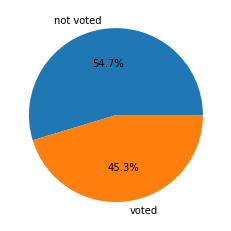

In [11]:
plt.pie([train['voted'].mean(),1-train['voted'].mean()], labels = ['not voted','voted'], autopct='%.1f%%')
plt.show()

### 종속변수와 상관관계 확인

In [12]:
train.corr()['voted'].sort_values()[:10]

education   -0.319899
married     -0.214489
QqA         -0.123306
wr_11       -0.116734
wr_01       -0.107857
wr_06       -0.102477
tp08        -0.099384
wr_03       -0.097774
wr_05       -0.094075
QkA         -0.089467
Name: voted, dtype: float64

In [13]:
train.corr()['voted'].sort_values(ascending=False)[:10]

voted    1.000000
QbA      0.099209
QtA      0.092549
tp07     0.088710
QpA      0.085131
QjA      0.083216
tp03     0.082255
QmA      0.081733
tp09     0.079059
QoA      0.072746
Name: voted, dtype: float64

### familysize 분포

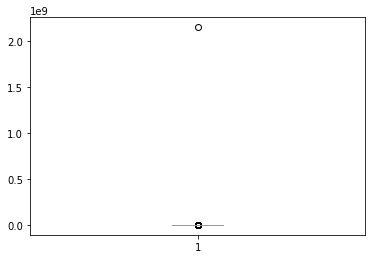

In [14]:
plt.boxplot(train['familysize'])

plt.show()

# 이상치 존재

### 시간관련 변수 분포

In [15]:
# 시간과 관련된 numerical한 변수
time_v = ['QaE','QbE','QcE','QdE','QeE','QfE','QgE','QhE','QiE','QjE','QkE','QlE','QmE','QnE','QoE','QpE','QqE','QrE','QsE','QtE']

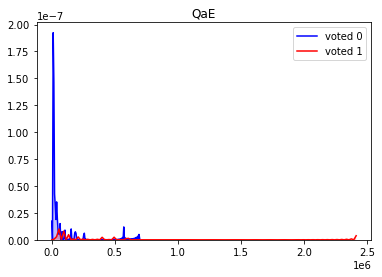

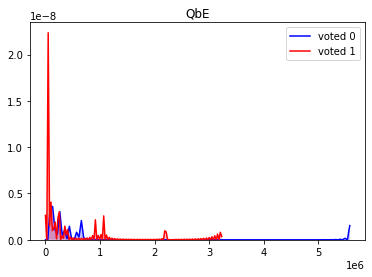

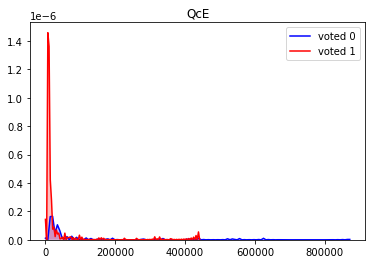

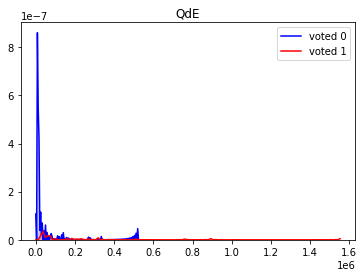

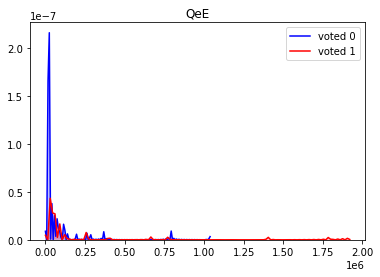

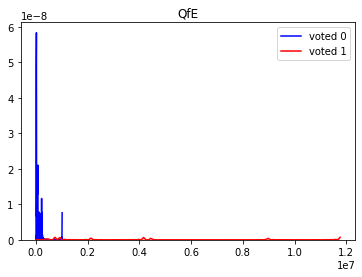

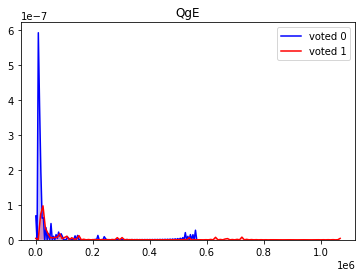

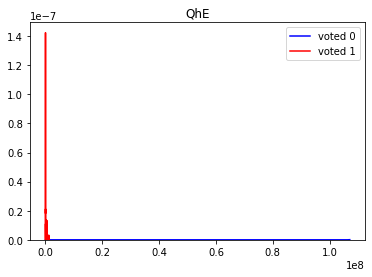

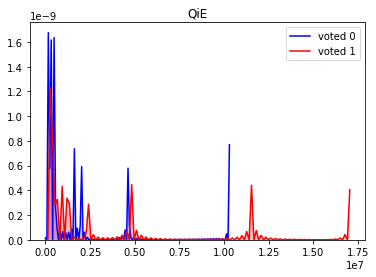

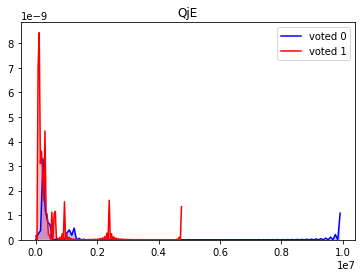

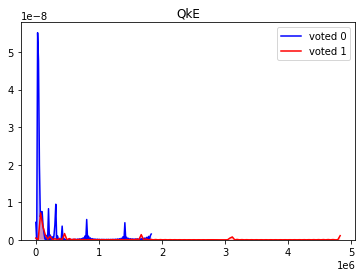

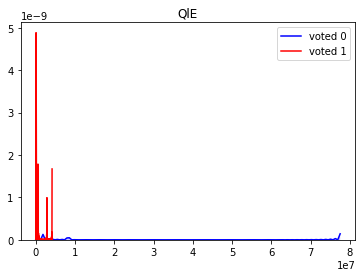

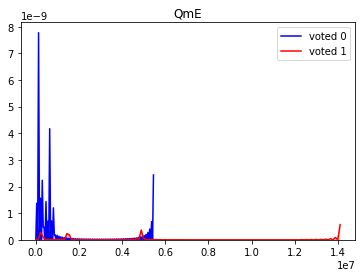

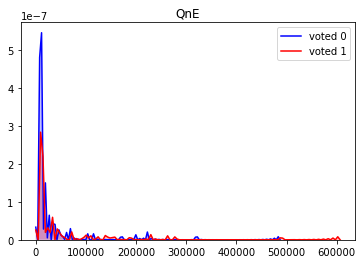

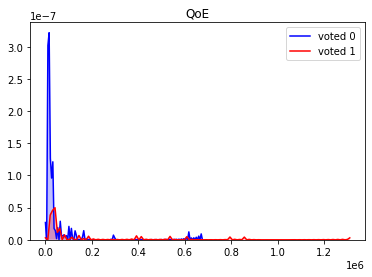

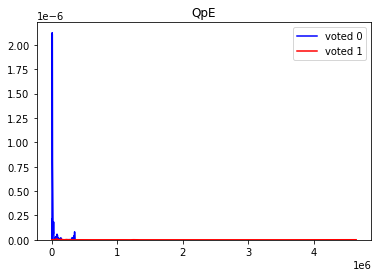

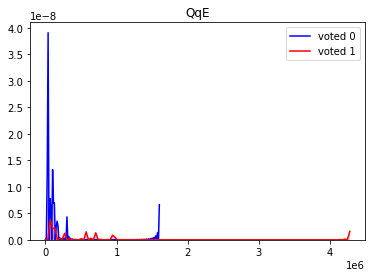

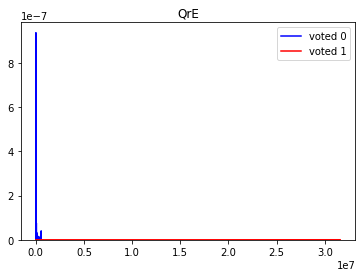

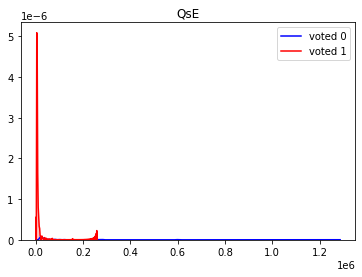

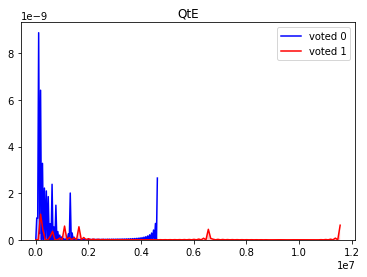

In [16]:
# 수치형 변수 분포 확인

for col in time_v:
    plt.title(col)
    sns.kdeplot(train.loc[train.voted==0,col], color = 'blue', shade=True, label = 'voted 0')
    sns.kdeplot(train.loc[train.voted==1,col], color = 'red', shade=True, label = 'voted 1')
    plt.show()
    
# 오른쪽으로 꼬리가 긴 분포 형태

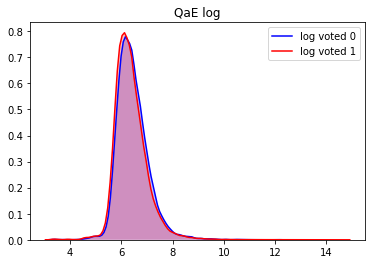

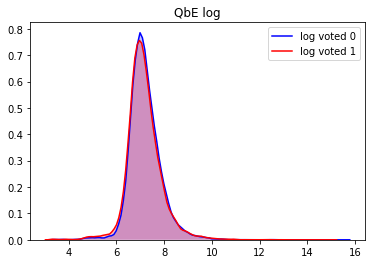

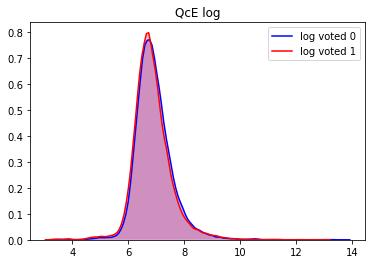

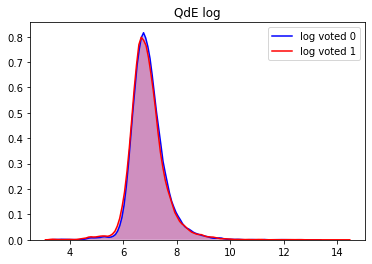

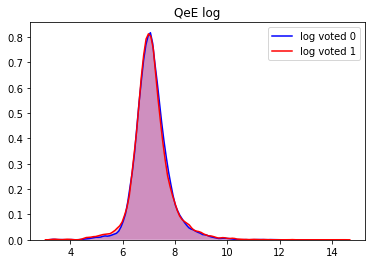

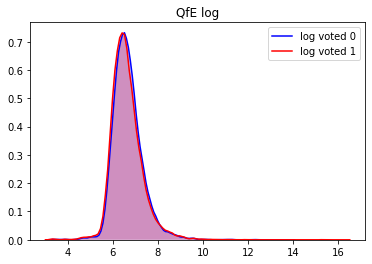

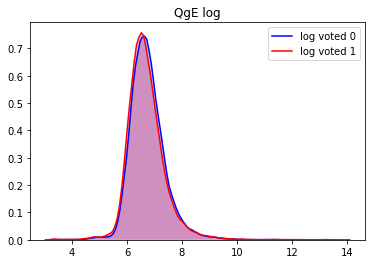

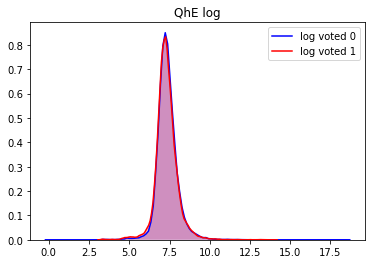

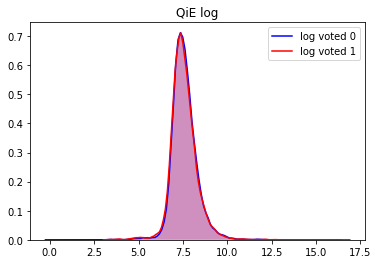

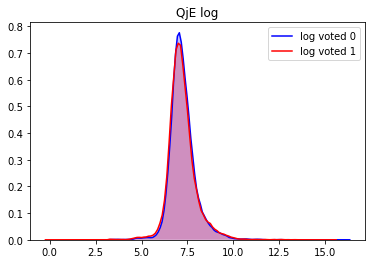

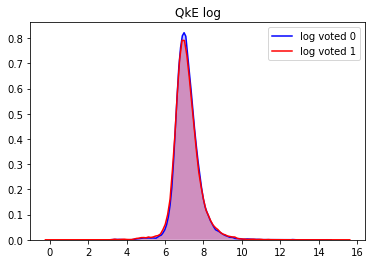

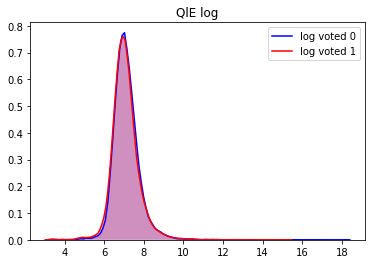

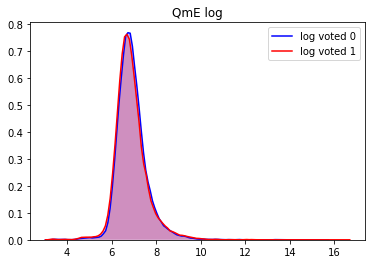

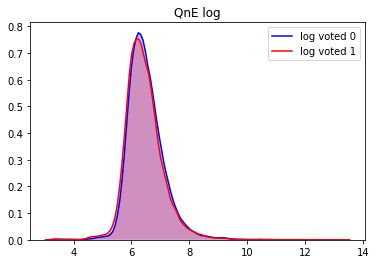

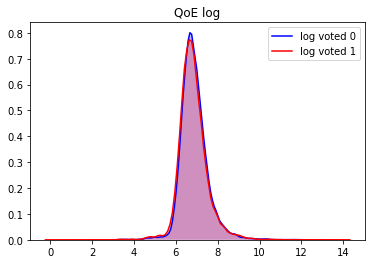

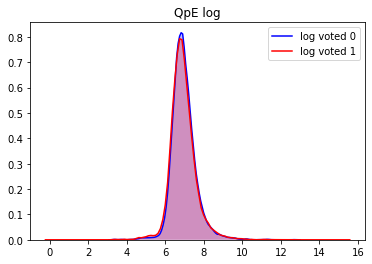

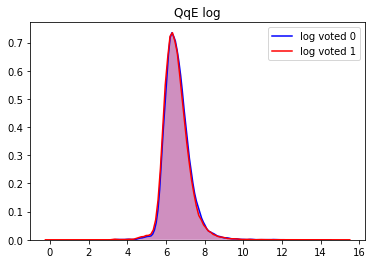

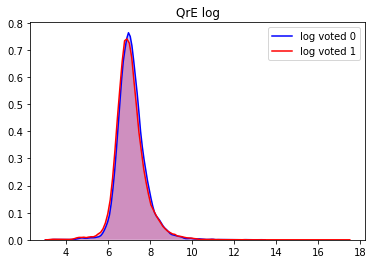

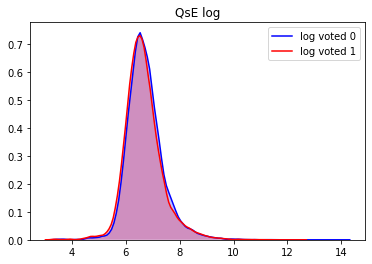

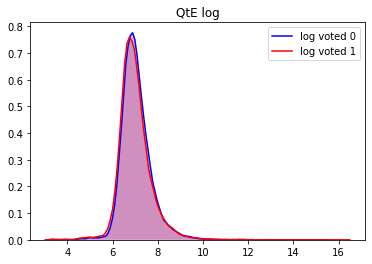

In [17]:
# 로그 변환 후 분포 확인

for col in time_v:
    plt.title(col+' log')
    sns.kdeplot(np.log1p(train.loc[train.voted==0,col]), color = 'blue', shade=True, label = 'log voted 0')
    sns.kdeplot(np.log1p(train.loc[train.voted==1,col]), color = 'red', shade=True, label = 'log voted 1')
    plt.show()

# voted 0과 1에 따른 변수 분포 차이가 없음

In [18]:
# # 이상치 대체 후 분포 확인

# for col in time_v:
#     plt.title(col+' outlier drop')
#     Q1 = np.percentile(train[col],25)
#     Q3 = np.percentile(train[col],75)
#     IQR = Q3-Q1
#     outerlier_range = IQR * 1.5
#     upstep = Q3+outerlier_range
#     downstep = Q1-outerlier_range
#     train.loc[train[col]>=upstep,col] = upstep
#     train.loc[train[col]<=downstep,col] = downstep    
#     sns.kdeplot(train.loc[train.voted==0,col], color = 'blue', shade=True, label = 'log voted 0')
#     sns.kdeplot(train.loc[train.voted==1,col], color = 'red', shade=True, label = 'log voted 1')
#     plt.show()
    
# # voted 0과 1에 따른 변수 분포 차이가 없어보임
# # 모델 결과로 확인해보자!

### 이산형변수

In [19]:
descrete_v = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 'QkA', 'QlA', 'QmA', 'QnA', 'QoA',
              'QpA', 'QqA', 'QrA', 'QsA', 'QtA','age_group', 'education', 'engnat', 'gender', 'hand',
              'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05','tp06', 'tp07', 'tp08', 'tp09', 'tp10',
              'urban', 'wf_01','wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
              'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

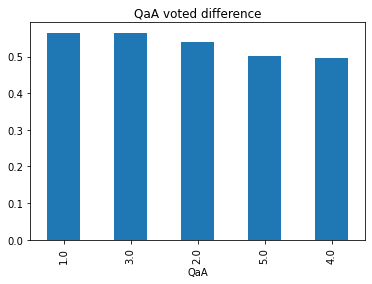

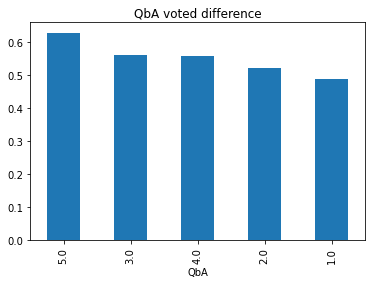

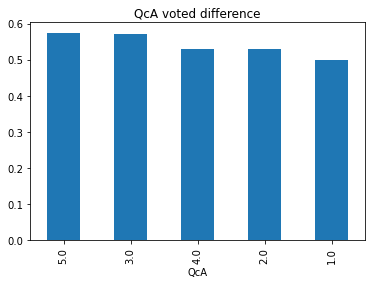

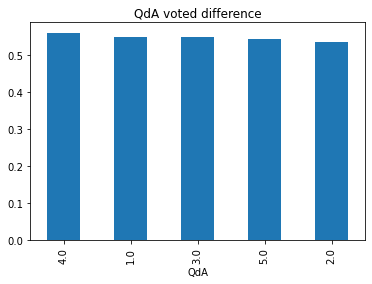

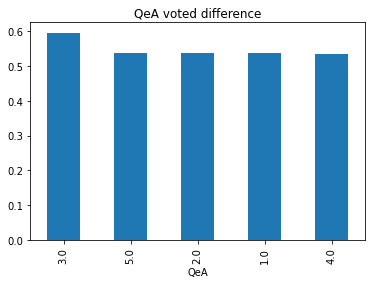

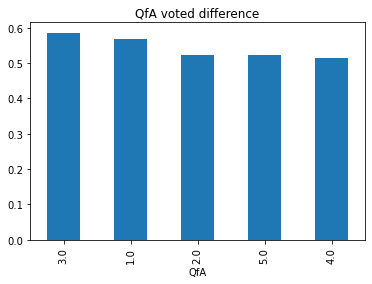

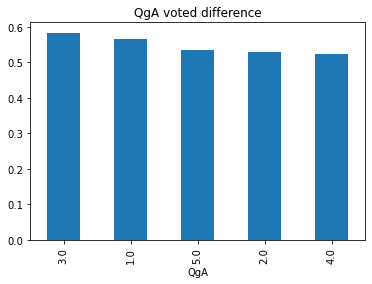

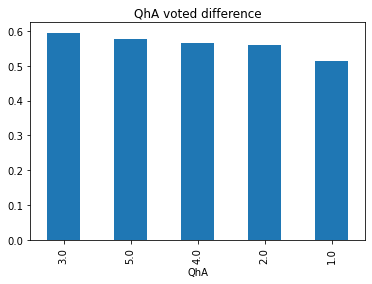

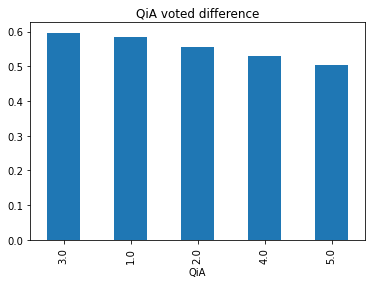

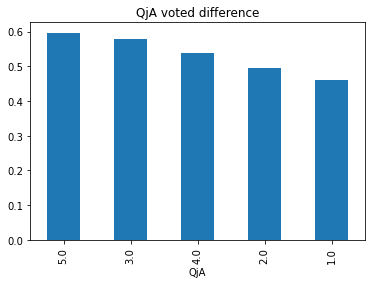

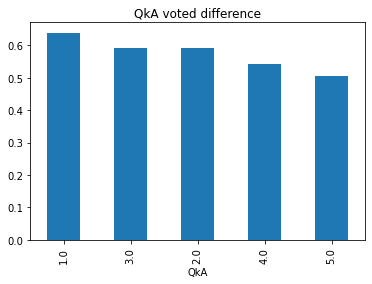

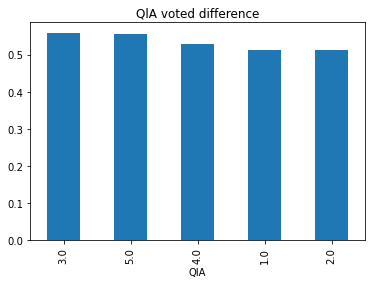

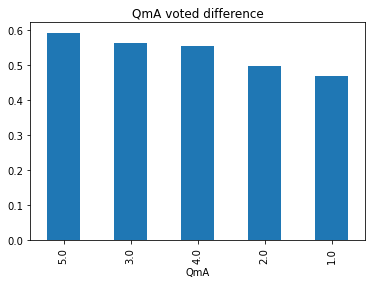

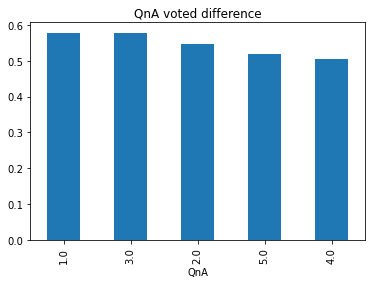

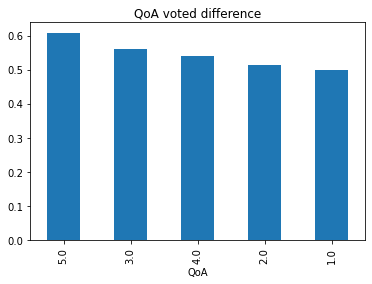

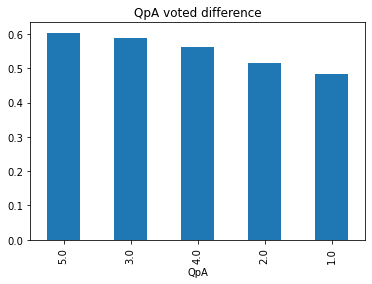

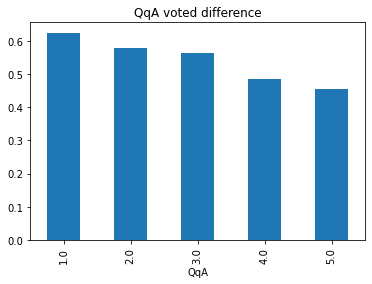

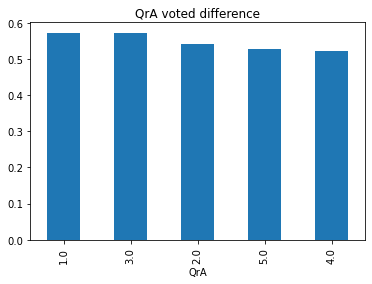

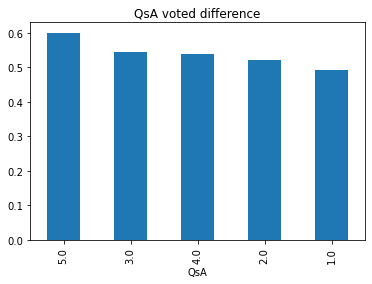

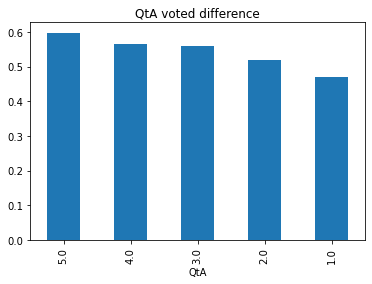

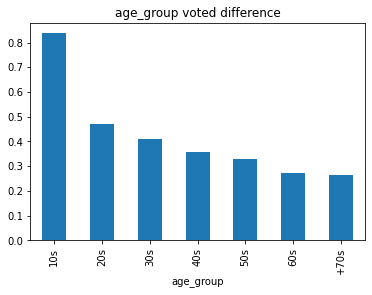

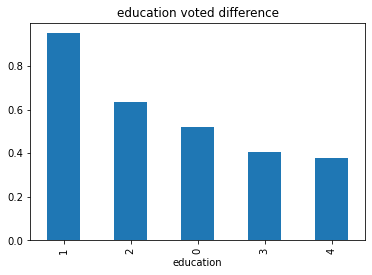

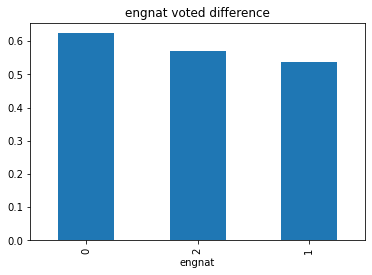

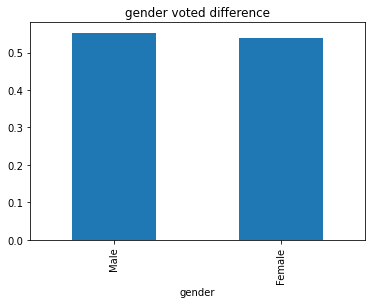

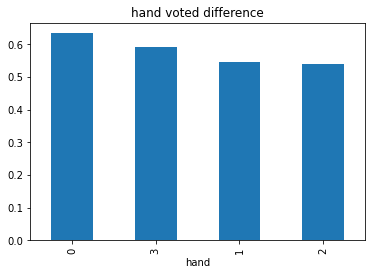

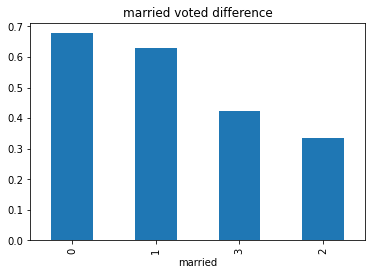

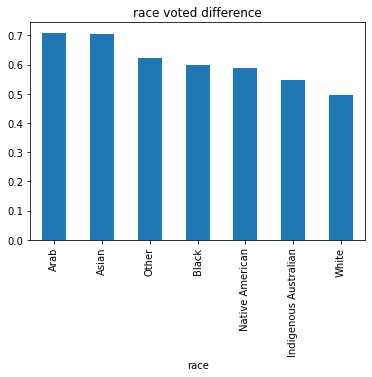

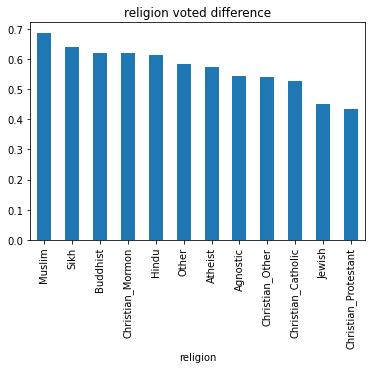

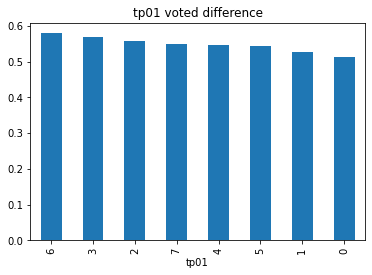

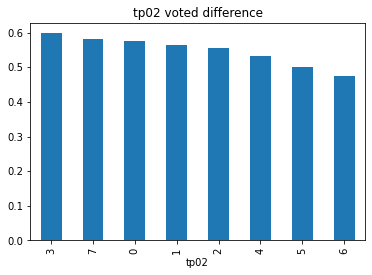

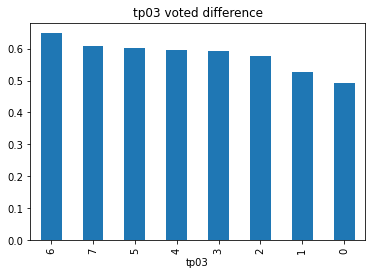

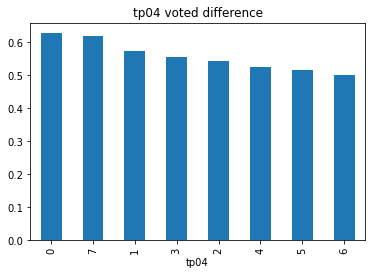

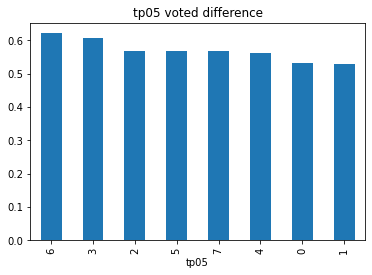

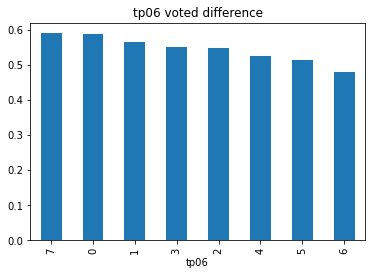

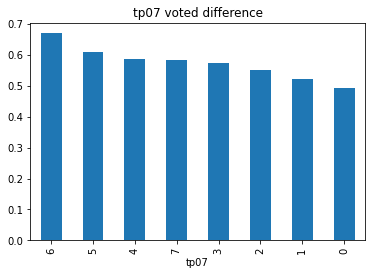

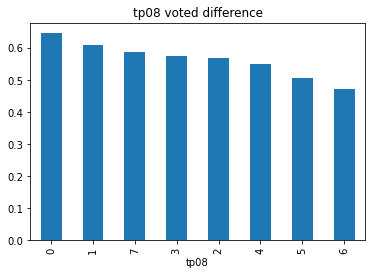

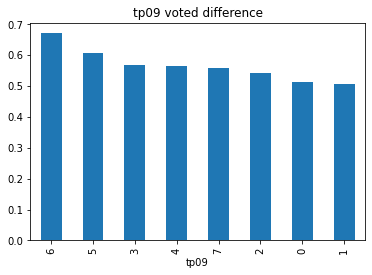

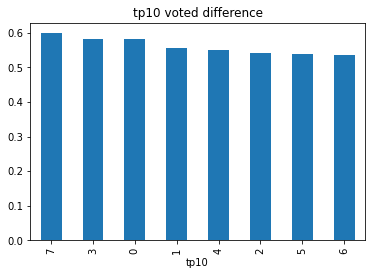

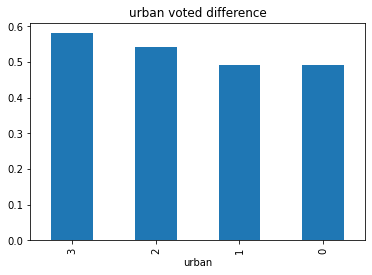

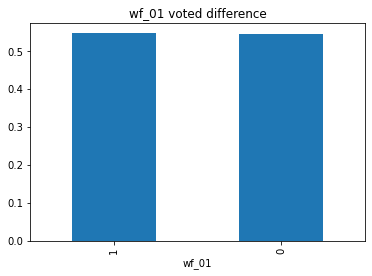

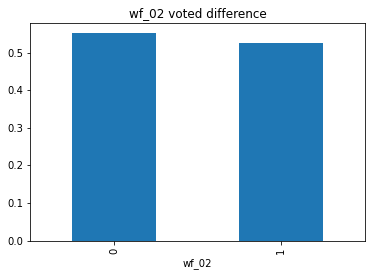

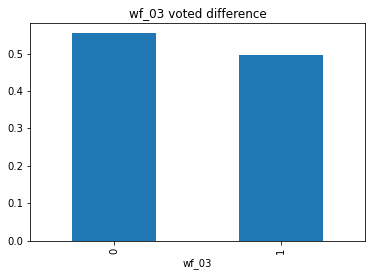

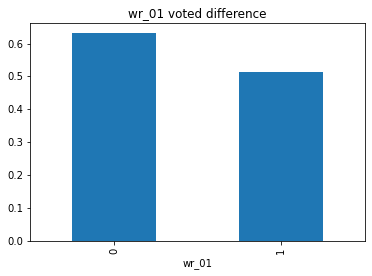

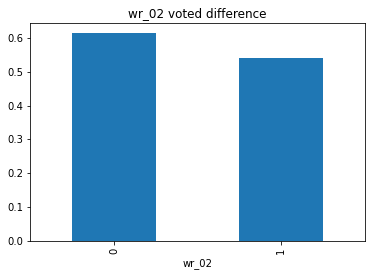

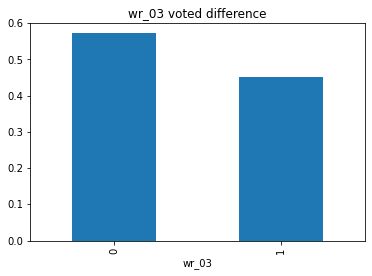

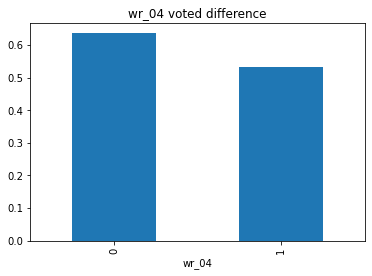

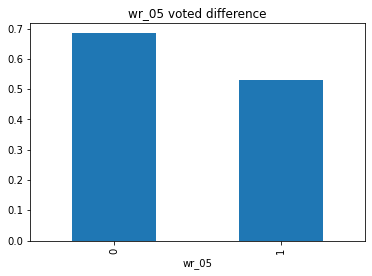

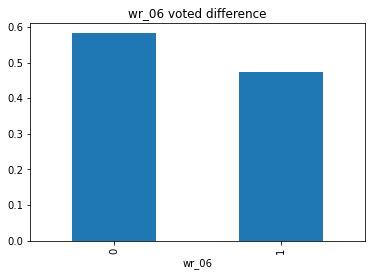

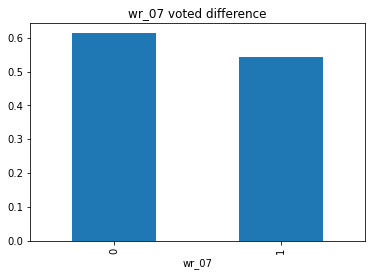

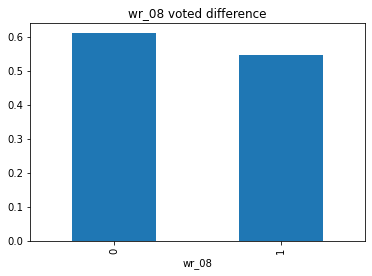

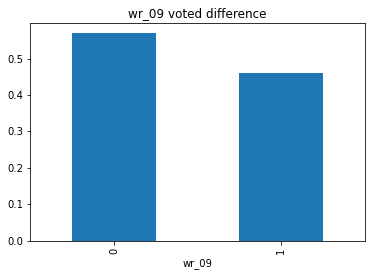

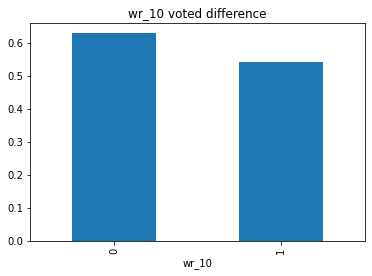

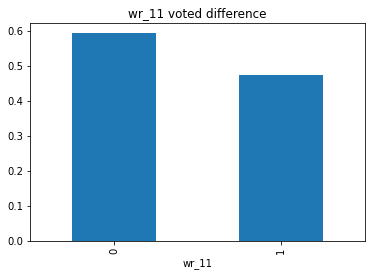

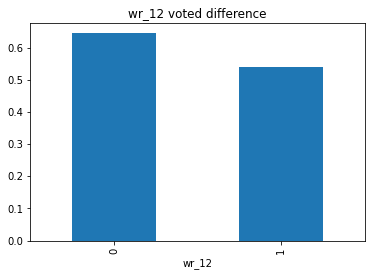

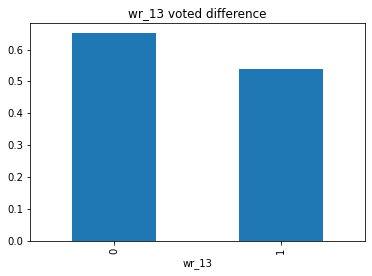

In [20]:
# 이산형 변수에 따른 voted 차이 확인

for col in descrete_v:
    plt.title(col+' voted difference')
    train.groupby(col).mean()['voted'].sort_values(ascending=False).plot(kind='bar')
    plt.show()
    
# QjA, QmA
# age_group, education, married, race, religion, tp07, tp08, tp09 변수는 값에 따라 투표할 확률이 다름

# 이상치 대체

In [27]:
# familysize 변수 이상치 대체

Q1 = np.percentile(train['familysize'],25)
Q3 = np.percentile(train['familysize'],75)
IQR = Q3-Q1
outerlier_range = IQR * 1.5
Q3+outerlier_range
train.loc[train['familysize']>=4.5,'familysize'] = 5
test.loc[test['familysize']>=4.5,'familysize'] = 5

In [28]:
# 시간관련 변수 이상치 대체

for col in time_v:
    Q1 = np.percentile(train[col],25)
    Q3 = np.percentile(train[col],75)
    IQR = Q3-Q1
    outerlier_range = IQR * 1.5
    upstep = Q3+outerlier_range
    downstep = Q1-outerlier_range
    train.loc[train[col]>=upstep,col] = upstep
    test.loc[test[col]>=upstep,col] = upstep
    train.loc[train[col]<=downstep,col] = downstep
    test.loc[test[col]<=downstep,col] = downstep

# 파생변수 생성

## 로그변환

In [158]:
# for col in time_v:
#     train[col+'_log'] = np.log1p(train[col])
#     train = train.drop(col,axis=1)
    
#     test[col+'_log'] = np.log1p(test[col])
#     test = test.drop(col,axis=1)
    
# train.head()

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,...,QkE_log,QlE_log,QmE_log,QnE_log,QoE_log,QpE_log,QqE_log,QrE_log,QsE_log,QtE_log
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,...,6.784457,6.747587,6.747587,6.705639,6.363028,6.829794,5.905362,6.776507,6.452049,7.017506
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,...,7.987524,8.275886,8.373323,7.511525,7.102499,7.789455,7.213032,8.019613,8.367532,7.205635
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,...,6.906755,7.843064,6.823286,7.675082,7.173958,7.031741,6.843750,7.191429,7.065613,7.251345
3,3.0,3.0,4.0,3.0,1.0,2.0,4.0,3.0,5.0,4.0,...,8.077137,7.167809,9.110188,7.104144,7.064759,10.080336,6.366470,9.086024,7.780303,7.180070
4,1.0,1.0,5.0,2.0,1.0,2.0,1.0,1.0,5.0,5.0,...,6.608001,7.074963,6.306275,6.356108,6.626718,7.039660,5.780744,6.976348,6.369901,7.544332


## 마키아벨리즘 Score

In [308]:
# train_t = train.copy()
# test_t = test.copy()

In [309]:
# Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
#              'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
#              'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
#              'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

### 기존에 알고 있는 feature reverse

In [310]:
# # 기존에 알고 있는 feature reverse
# flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
# for flip in flipping_columns: 
#     train_t[flip] = 6 - train_t[flip]
#     test_t[flip] = 6 - test_t[flip]

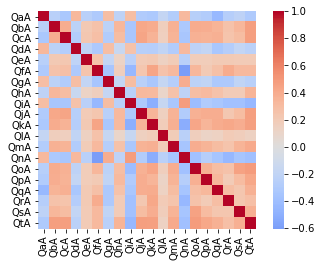

In [311]:
# correlations = train_t[Answers].corr(method = 'spearman')
# sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

### secret feature reverse

In [312]:
# # secret feature reverse
# flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
# for flip in flipping_secret_columns: 
#     train_t[flip] = 6 - train_t[flip]
#     test_t[flip] = 6 - test_t[flip]

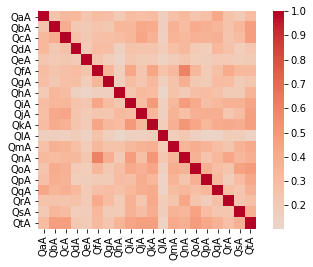

In [313]:
# correlations = train_t[Answers].corr(method='spearman')
# sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

### 마키아벨리즘 테스트스코어 피쳐 추가

In [314]:
# train_t['Mach_score'] = train_t[Answers].mean(axis = 1)
# test_t['Mach_score'] = test_t[Answers].mean(axis = 1)
# train['Mach_score'] = train_t['Mach_score']
# test['Mach_score'] = test_t['Mach_score']

# train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Mach_score
0,3.0,363.0,4.0,1370.0,5.0,997.0,1.0,1024.0,2.0,1577.0,...,1,0,1,1,0,1,0,1,1,2.95
1,5.0,647.0,5.0,1313.0,3.0,2361.0,5.0,2369.0,1.0,2889.0,...,1,0,1,1,0,1,0,1,1,2.60
2,4.0,1461.5,1.0,1480.0,1.0,1021.0,4.0,2369.0,5.0,1333.0,...,1,0,1,1,1,1,0,1,1,1.90
3,3.0,504.0,3.0,2311.0,4.0,992.0,3.0,2369.0,1.0,357.0,...,0,0,0,1,0,1,0,1,1,3.35
4,1.0,927.0,1.0,707.0,5.0,556.0,2.0,1062.0,1.0,1014.0,...,1,1,1,1,0,1,1,1,1,3.00


## TIPI

In [29]:
train['Extraversion_sum'] = train['tp01'] + (8-train['tp06'])
test['Extraversion_sum'] = test['tp01'] + (8-test['tp06'])

train['Agreeable_sum'] = (8-train['tp02']) + train['tp07']
test['Agreeable_sum'] = (8-test['tp02']) + test['tp07']

train['Conscient_sum'] = train['tp03'] + (8-train['tp08'])
test['Conscient_sum'] = test['tp03'] + (8-test['tp08'])

train['Emotion_sum'] = (8-train['tp04']) + train['tp09']
test['Emotion_sum'] = (8-test['tp04']) + test['tp09']

train['OpenEx_sum'] = train['tp05'] + (8-train['tp10'])
test['OpenEx_sum'] = test['tp05'] + (8-test['tp10'])

## 범주형변수 교호작용

In [108]:
# age_group, education, married, race, religion, tp07, tp08, tp09, wr03, wr05

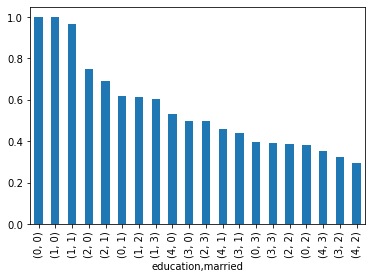

In [147]:
# # 종속변수와 가장 상관계수 절댓값이 큰 두 변수 교차

# train.groupby(['education','married']).mean()['voted'].sort_values(ascending=False).plot(kind='bar')
# plt.show()

In [148]:
# f = train.groupby(['education','married']).mean()['voted'].sort_values(ascending=False).reset_index()
# f['cut'] = pd.qcut(f.voted,5)
# f.groupby('cut').count()

,education,married,voted
cut,,,
"(0.293, 0.386]",4,4,4
"(0.386, 0.452]",4,4,4
"(0.452, 0.56]",4,4,4
"(0.56, 0.703]",4,4,4
"(0.703, 1.0]",4,4,4


In [158]:
# edumar_1 = []
# for i in range(4):
#     edumar_1.append([f.loc[i,'education'],f.loc[i,'married']])

# for j in range(len(edumar_1)):
#     train.loc[(train.education == edumar_1[j][0]) & (train.married == edumar_1[j][1]),"edumar"] = 1
#     test.loc[(test.education == edumar_1[j][0]) & (test.married == edumar_1[j][1]),"edumar"] = 1

In [159]:
# edumar_2 = []
# for i in range(4,8):
#     edumar_2.append([f.loc[i,'education'],f.loc[i,'married']])

# for j in range(len(edumar_2)):
#     train.loc[(train.education == edumar_2[j][0]) & (train.married == edumar_2[j][1]),"edumar"] = 2
#     test.loc[(test.education == edumar_2[j][0]) & (test.married == edumar_2[j][1]),"edumar"] = 2

In [160]:
# edumar_3 = []
# for i in range(8,12):
#     edumar_3.append([f.loc[i,'education'],f.loc[i,'married']])

# for j in range(len(edumar_3)):
#     train.loc[(train.education == edumar_3[j][0]) & (train.married == edumar_3[j][1]),"edumar"] = 3
#     test.loc[(test.education == edumar_3[j][0]) & (test.married == edumar_3[j][1]),"edumar"] = 3

In [161]:
# edumar_4 = []
# for i in range(12,16):
#     edumar_4.append([f.loc[i,'education'],f.loc[i,'married']])

# for j in range(len(edumar_4)):
#     train.loc[(train.education == edumar_4[j][0]) & (train.married == edumar_4[j][1]),"edumar"] = 4
#     test.loc[(test.education == edumar_4[j][0]) & (test.married == edumar_4[j][1]),"edumar"] = 4

In [162]:
# edumar_5 = []
# for i in range(16,20):
#     edumar_5.append([f.loc[i,'education'],f.loc[i,'married']])

# for j in range(len(edumar_5)):
#     train.loc[(train.education == edumar_5[j][0]) & (train.married == edumar_5[j][1]),"edumar"] = 5
#     test.loc[(test.education == edumar_5[j][0]) & (test.married == edumar_5[j][1]),"edumar"] = 5

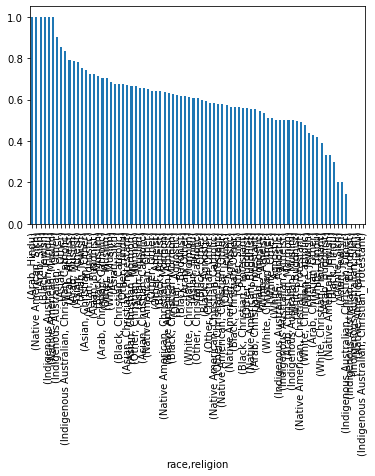

In [130]:
# # race , religion

# train.groupby(['race','religion']).mean()['voted'].sort_values(ascending=False).plot(kind='bar')
# plt.show()

In [131]:
# f = train.groupby(['race','religion']).mean()['voted'].sort_values(ascending=False).reset_index()
# f['cut'] = pd.qcut(f.voted,5)
# f.groupby('cut').count()

,race,religion,voted
cut,,,
"(-0.001, 0.497]",17,17,17
"(0.497, 0.564]",16,16,16
"(0.564, 0.636]",16,16,16
"(0.636, 0.716]",16,16,16
"(0.716, 1.0]",16,16,16


In [132]:
# rr_1 = []
# for i in range(17):
#     rr_1.append([f.loc[i,'race'],f.loc[i,'religion']])

# for j in range(len(rr_1)):
#     train.loc[(train.race == rr_1[j][0]) & (train.religion == rr_1[j][1]),"rac_rel"] = 1
#     test.loc[(test.race == rr_1[j][0]) & (test.religion == rr_1[j][1]),"rac_rel"] = 1

In [133]:
# rr_2 = []
# for i in range(17,33):
#     rr_2.append([f.loc[i,'race'],f.loc[i,'religion']])

# for j in range(len(rr_2)):
#     train.loc[(train.race == rr_2[j][0]) & (train.religion == rr_2[j][1]),"rac_rel"] = 2
#     test.loc[(test.race == rr_2[j][0]) & (test.religion == rr_2[j][1]),"rac_rel"] = 2

In [134]:
# rr_3 = []
# for i in range(33,49):
#     rr_3.append([f.loc[i,'race'],f.loc[i,'religion']])

# for j in range(len(rr_3)):
#     train.loc[(train.race == rr_3[j][0]) & (train.religion == rr_3[j][1]),"rac_rel"] = 3
#     test.loc[(test.race == rr_3[j][0]) & (test.religion == rr_3[j][1]),"rac_rel"] = 3

In [135]:
# rr_4 = []
# for i in range(49,65):
#     rr_4.append([f.loc[i,'race'],f.loc[i,'religion']])

# for j in range(len(rr_4)):
#     train.loc[(train.race == rr_4[j][0]) & (train.religion == rr_4[j][1]),"rac_rel"] = 4
#     test.loc[(test.race == rr_4[j][0]) & (test.religion == rr_4[j][1]),"rac_rel"] = 4

In [136]:
# rr_5 = []
# for i in range(65,81):
#     rr_5.append([f.loc[i,'race'],f.loc[i,'religion']])

# for j in range(len(rr_5)):
#     train.loc[(train.race == rr_5[j][0]) & (train.religion == rr_5[j][1]),"rac_rel"] = 5
#     test.loc[(test.race == rr_5[j][0]) & (test.religion == rr_5[j][1]),"rac_rel"] = 5

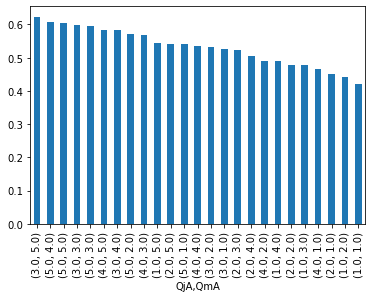

In [30]:
# # 가장 종속변수 분포가 차익나던 질문 QjA, QmA

# train.groupby(['QjA','QmA']).mean()['voted'].sort_values(ascending=False).plot(kind='bar')
# plt.show()

In [31]:
# f = train.groupby(['QjA','QmA']).mean()['voted'].sort_values(ascending=False).reset_index()
# f['cut'] = pd.qcut(f.voted,5)
# f.groupby('cut').count()

,QjA,QmA,voted
cut,,,
"(0.419, 0.478]",5,5,5
"(0.478, 0.524]",5,5,5
"(0.524, 0.544]",5,5,5
"(0.544, 0.586]",5,5,5
"(0.586, 0.623]",5,5,5


In [32]:
# QjmA_1 = []

# for i in range(5):
#     QjmA_1.append([f.loc[i,'QjA'],f.loc[i,'QmA']])

# for j in range(len(QjmA_1)):
#     train.loc[(train.QjA == QjmA_1[j][0]) & (train.QmA == QjmA_1[j][1]),"QjmA"] = 1
#     test.loc[(test.QjA == QjmA_1[j][0]) & (test.QmA == QjmA_1[j][1]),"QjmA"] = 1

In [33]:
# QjmA_2 = []

# for i in range(5,10):
#     QjmA_2.append([f.loc[i,'QjA'],f.loc[i,'QmA']])

# for j in range(len(QjmA_1)):
#     train.loc[(train.QjA == QjmA_2[j][0]) & (train.QmA == QjmA_2[j][1]),"QjmA"] = 2
#     test.loc[(test.QjA == QjmA_2[j][0]) & (test.QmA == QjmA_2[j][1]),"QjmA"] = 2

In [34]:
# QjmA_3 = []

# for i in range(10,15):
#     QjmA_3.append([f.loc[i,'QjA'],f.loc[i,'QmA']])

# for j in range(len(QjmA_3)):
#     train.loc[(train.QjA == QjmA_3[j][0]) & (train.QmA == QjmA_3[j][1]),"QjmA"] = 3
#     test.loc[(test.QjA == QjmA_3[j][0]) & (test.QmA == QjmA_3[j][1]),"QjmA"] = 3

In [35]:
# QjmA_4 = []

# for i in range(15,20):
#     QjmA_4.append([f.loc[i,'QjA'],f.loc[i,'QmA']])

# for j in range(len(QjmA_4)):
#     train.loc[(train.QjA == QjmA_4[j][0]) & (train.QmA == QjmA_4[j][1]),"QjmA"] = 4
#     test.loc[(test.QjA == QjmA_4[j][0]) & (test.QmA == QjmA_4[j][1]),"QjmA"] = 4

In [36]:
# QjmA_5 = []

# for i in range(20,25):
#     QjmA_5.append([f.loc[i,'QjA'],f.loc[i,'QmA']])

# for j in range(len(QjmA_5)):
#     train.loc[(train.QjA == QjmA_5[j][0]) & (train.QmA == QjmA_5[j][1]),"QjmA"] = 5
#     test.loc[(test.QjA == QjmA_5[j][0]) & (test.QmA == QjmA_5[j][1]),"QjmA"] = 5

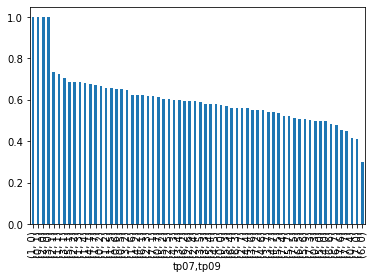

In [37]:
# # tp 관련 두 변수 교차 (tp07과 tp09는 서로 비슷한 맥락)

# train.groupby(['tp07','tp09']).mean()['voted'].sort_values(ascending=False).plot(kind='bar')
# plt.show()

In [38]:
# f = train.groupby(['tp07','tp09']).mean()['voted'].sort_values(ascending=False).reset_index()
# f['cut'] = pd.qcut(f.voted,5)
# f.groupby('cut').count()

,tp07,tp09,voted
cut,,,
"(0.299, 0.512]",13,13,13
"(0.512, 0.564]",13,13,13
"(0.564, 0.604]",12,12,12
"(0.604, 0.668]",13,13,13
"(0.668, 1.0]",13,13,13


In [39]:
# tp79_1 = []
# for i in range(10):
#     tp79_1.append([f.loc[i,'tp07'],f.loc[i,'tp09']])

# for j in range(len(tp79_1)):
#     train.loc[(train.tp07 == tp79_1[j][0]) & (train.tp09 == tp79_1[j][1]),"tp79"] = 1
#     test.loc[(train.tp07 == tp79_1[j][0]) & (test.tp09 == tp79_1[j][1]),"tp79"] = 1

In [40]:
# tp79_2 = []
# for i in range(10,20):
#     tp79_2.append([f.loc[i,'tp07'],f.loc[i,'tp09']])

# for j in range(len(tp79_2)):
#     train.loc[(train.tp07 == tp79_2[j][0]) & (train.tp09 == tp79_2[j][1]),"tp79"] = 2
#     test.loc[(train.tp07 == tp79_2[j][0]) & (test.tp09 == tp79_2[j][1]),"tp79"] = 2

In [41]:
# tp79_3 = []
# for i in range(20,29):
#     tp79_3.append([f.loc[i,'tp07'],f.loc[i,'tp09']])

# for j in range(len(tp79_3)):
#     train.loc[(train.tp07 == tp79_3[j][0]) & (train.tp09 == tp79_3[j][1]),"tp79"] = 3
#     test.loc[(train.tp07 == tp79_3[j][0]) & (test.tp09 == tp79_3[j][1]),"tp79"] = 3

In [42]:
# tp79_4 = []
# for i in range(29,39):
#     tp79_4.append([f.loc[i,'tp07'],f.loc[i,'tp09']])

# for j in range(len(tp79_4)):
#     train.loc[(train.tp07 == tp79_4[j][0]) & (train.tp09 == tp79_4[j][1]),"tp79"] = 4
#     test.loc[(train.tp07 == tp79_4[j][0]) & (test.tp09 == tp79_4[j][1]),"tp79"] = 4

In [43]:
# tp79_5 = []
# for i in range(39,49):
#     tp79_5.append([f.loc[i,'tp07'],f.loc[i,'tp09']])

# for j in range(len(tp79_5)):
#     train.loc[(train.tp07 == tp79_5[j][0]) & (train.tp09 == tp79_5[j][1]),"tp79"] = 5
#     test.loc[(train.tp07 == tp79_5[j][0]) & (test.tp09 == tp79_5[j][1]),"tp79"] = 5

# 범주형 데이터 변환

## one-hot encoding + PCA

In [30]:
train_ohe = train.copy()
test_ohe = test.copy()

In [32]:
train_ohe['age_group'] = train_ohe['age_group'].astype('category').cat.codes
train_ohe['gender'] = train_ohe['gender'].astype('category').cat.codes
train_ohe['race'] = train_ohe['race'].astype('category').cat.codes
train_ohe['religion'] = train_ohe['religion'].astype('category').cat.codes
train_ohe['education'] = train_ohe['education'].astype('category').cat.codes
train_ohe['engnat'] = train_ohe['engnat'].astype('category').cat.codes
train_ohe['hand'] = train_ohe['hand'].astype('category').cat.codes
train_ohe['married'] = train_ohe['married'].astype('category').cat.codes
train_ohe['urban'] = train_ohe['urban'].astype('category').cat.codes

test_ohe['age_group'] = test_ohe['age_group'].astype('category').cat.codes
test_ohe['gender'] = test_ohe['gender'].astype('category').cat.codes
test_ohe['race'] = test_ohe['race'].astype('category').cat.codes
test_ohe['religion'] = test_ohe['religion'].astype('category').cat.codes
test_ohe['education'] = test_ohe['education'].astype('category').cat.codes
test_ohe['engnat'] = test_ohe['engnat'].astype('category').cat.codes
test_ohe['hand'] = test_ohe['hand'].astype('category').cat.codes
test_ohe['married'] = test_ohe['married'].astype('category').cat.codes
test_ohe['urban'] = test_ohe['urban'].astype('category').cat.codes


train_ohe[['age_group','gender','race','religion','education','engnat','hand','married','urban']]
#test_ohe[['age_group','gender','race','religion','education','engnat','hand','married','urban']]

,age_group,gender,race,religion,education,engnat,hand,married,urban
0,3,0,6,10,2,1,1,3,1
1,2,0,1,7,4,2,1,1,3
2,3,1,6,10,3,1,1,2,2
3,2,0,1,7,4,2,1,1,3
4,2,1,6,0,3,1,1,2,1
...,...,...,...,...,...,...,...,...,...
45527,1,0,6,8,2,1,3,1,3
45528,3,1,6,1,2,1,1,1,1
45529,1,0,6,5,2,1,1,1,2
45530,4,1,6,1,4,1,3,1,0


In [33]:
train_ohe_df = pd.concat([pd.get_dummies(train_ohe['age_group']), pd.get_dummies(train_ohe['gender']),
                          pd.get_dummies(train_ohe['race']), pd.get_dummies(train_ohe['religion']),
                          pd.get_dummies(train_ohe['education']),pd.get_dummies(train_ohe['engnat']),
                          pd.get_dummies(train_ohe['engnat']),pd.get_dummies(train_ohe['married']),
                         pd.get_dummies(train_ohe['urban'])], axis=1)

test_ohe_df = pd.concat([pd.get_dummies(test_ohe['age_group']), pd.get_dummies(test_ohe['gender']),
                          pd.get_dummies(test_ohe['race']), pd.get_dummies(test_ohe['religion']),
                          pd.get_dummies(test_ohe['education']),pd.get_dummies(test_ohe['engnat']),
                          pd.get_dummies(test_ohe['engnat']),pd.get_dummies(test_ohe['married']),
                         pd.get_dummies(test_ohe['urban'])], axis=1)

In [34]:
train_ohe_df

,0,1,2,3,4,5,6,0,1,0,...,1,2,0,1,2,3,0,1,2,3
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
45528,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
45529,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
45530,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


In [35]:
pca = PCA(n_components= 47)
pca.fit(train_ohe_df)

print(pca.explained_variance_ratio_)  # 차원을 축소하여 전체 columns를 얼마나 설명하는지를 나타낸다.

[1.73478138e-01 1.08811322e-01 9.42482869e-02 7.34871830e-02
 6.79155161e-02 5.26278437e-02 4.82148317e-02 4.22697162e-02
 4.01465058e-02 3.91097403e-02 3.26699791e-02 2.89022513e-02
 2.43303064e-02 2.31679463e-02 2.20837102e-02 2.05844838e-02
 1.95319362e-02 1.74990225e-02 1.40618690e-02 1.06933568e-02
 9.56862063e-03 5.58870429e-03 5.41544439e-03 5.31357665e-03
 3.85421787e-03 2.89402747e-03 2.72977898e-03 2.22127305e-03
 1.87082019e-03 1.78628179e-03 1.52270231e-03 1.12805202e-03
 9.69128843e-04 5.27545932e-04 5.18321072e-04 2.57559183e-04
 5.30717794e-31 3.10516974e-32 1.42593708e-32 7.44112001e-33
 5.48141027e-33 4.72463488e-33 4.53942722e-33 4.42547818e-33
 2.13117893e-33 8.63786152e-34 1.58188007e-34]


In [36]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
deter = np.argmax(cumsum >= 0.99) + 1
print('차원의 수 : ', deter)

차원의 수 :  28


In [37]:
pca = PCA(n_components= 28)
train_ohe_df = pca.fit_transform(train_ohe_df)
train_ohe_df = pd.DataFrame(train_ohe_df)
train_ohe_df.columns = ['ohe_variable_{}'.format(x) for x in range(deter)]
train_ohe_df.head()


test_ohe_df = pca.transform(test_ohe_df)
test_ohe_df = pd.DataFrame(test_ohe_df)
test_ohe_df.columns = ['ohe_variable_{}'.format(x) for x in range(deter)]
test_ohe_df.head()

,ohe_variable_0,ohe_variable_1,ohe_variable_2,ohe_variable_3,ohe_variable_4,ohe_variable_5,ohe_variable_6,ohe_variable_7,ohe_variable_8,ohe_variable_9,...,ohe_variable_18,ohe_variable_19,ohe_variable_20,ohe_variable_21,ohe_variable_22,ohe_variable_23,ohe_variable_24,ohe_variable_25,ohe_variable_26,ohe_variable_27
0,1.074513,-0.983973,-0.282223,0.207729,1.289715,0.297496,-0.057979,-0.097235,-0.377038,-0.244649,...,-0.011654,-0.027018,-0.135233,-0.071040,-0.035305,-0.093775,0.011334,0.013431,0.000853,-0.008956
1,1.688555,-1.036086,0.210421,-0.777131,0.204205,-0.331057,0.098249,0.103534,-0.217111,-0.487461,...,-0.189134,-0.182389,-0.091008,-0.089176,-0.027104,-0.058790,0.024298,-0.027909,-0.002639,0.006031
2,1.327381,1.021102,-0.916700,-0.383216,0.473472,-0.207836,-0.160802,1.149088,0.245867,-0.807572,...,-0.048974,-0.299366,-0.049956,-0.102516,-0.023535,-0.070708,0.007974,-0.046212,-0.017703,0.017276
3,-0.764825,0.480260,-1.028970,-0.234912,0.782582,-0.589866,0.207124,-0.210452,0.148499,0.549392,...,-0.300946,-0.003361,-0.395816,-0.312325,-0.058717,0.854602,-0.043375,-0.012818,-0.039878,-0.032785
4,-0.715096,-1.278525,-0.295848,0.151505,0.532910,0.015199,0.227498,0.088025,-0.822517,0.105039,...,-0.224046,-0.039945,-0.130226,0.005424,-0.011221,-0.046596,0.004031,-0.002405,-0.000532,-0.021337


In [38]:
train_ohe = train_ohe.drop(['age_group','gender','race','religion','education','engnat','hand','married','urban'], axis=1)
train_ohe = pd.concat([train_ohe,train_ohe_df], axis=1)

test_ohe = test_ohe.drop(['age_group','gender','race','religion','education','engnat','hand','married','urban'], axis=1)
test_ohe = pd.concat([test_ohe,test_ohe_df], axis=1)

## label encoding

In [39]:
train_le = train.copy()
test_le = test.copy()

#labelencoding
label = LabelEncoder()

train_le['age_group_code'] = label.fit_transform(train_le['age_group'])
train_le['gender_code'] = label.fit_transform(train_le['gender'])
train_le['race_code'] = label.fit_transform(train_le['race'])
train_le['religion_code'] = label.fit_transform(train_le['religion'])

test_le['gender_code'] = label.fit_transform(test_le['gender'])
test_le['age_group_code'] = label.fit_transform(test_le['age_group'])
test_le['race_code'] = label.fit_transform(test_le['race'])
test_le['religion_code'] = label.fit_transform(test_le['religion'])

drop = ['gender','age_group','race','religion']
train_le = train_le.drop(drop, axis = 1)
test_le = test_le.drop(drop, axis = 1)
train_le[['gender_code','age_group_code','race_code','religion_code']].head()

,gender_code,age_group_code,race_code,religion_code
0,0,3,6,10
1,0,2,1,7
2,1,3,6,10
3,0,2,1,7
4,1,2,6,0


## mean encoding

In [40]:
train_me = train.copy()
test_me = test.copy()

# target 설정
target = 'voted'

# target 에 대한 각 변수의 mean 을 구함.
gender_mean = train_me.groupby('gender')[target].mean()
age_group_mean = train_me.groupby('age_group')[target].mean()
race_mean = train_me.groupby('race')[target].mean()
religion_mean = train_me.groupby('religion')[target].mean()
education_mean = train_me.groupby('education')[target].mean()
engnat_mean = train_me.groupby('engnat')[target].mean()
hand_mean = train_me.groupby('hand')[target].mean()
married_mean = train_me.groupby('married')[target].mean()
urban_mean = train_me.groupby('urban')[target].mean()

# 가존 변수에 encoded 된 값을 매핑
train_me['gender_mean'] = train_me['gender'].map(gender_mean)
train_me['age_group_mean'] = train_me['age_group'].map(age_group_mean)
train_me['race_mean'] = train_me['race'].map(race_mean)
train_me['religion_mean'] = train_me['religion'].map(religion_mean)
train_me['education_mean'] = train_me['education'].map(education_mean)
train_me['engnat_mean'] = train_me['engnat'].map(engnat_mean)
train_me['hand_mean'] = train_me['hand'].map(hand_mean)
train_me['married_mean'] = train_me['married'].map(married_mean)
train_me['urban_mean'] = train_me['urban'].map(urban_mean)


test_me['gender_mean'] = test_me['gender'].map(gender_mean)
test_me['age_group_mean'] = test_me['age_group'].map(age_group_mean)
test_me['race_mean'] = test_me['race'].map(race_mean)
test_me['religion_mean'] = test_me['religion'].map(religion_mean)
test_me['education_mean'] = test_me['education'].map(education_mean)
test_me['engnat_mean'] = test_me['engnat'].map(engnat_mean)
test_me['hand_mean'] = test_me['hand'].map(hand_mean)
test_me['married_mean'] = test_me['married'].map(married_mean)
test_me['urban_mean'] = test_me['urban'].map(urban_mean)


drop = ['gender','age_group','race','religion','education','engnat','hand','married','urban']
train_me = train_me.drop(drop, axis = 1)
test_me = test_me.drop(drop, axis = 1)
train_me[['gender_mean','age_group_mean','race_mean','religion_mean','education_mean','engnat_mean','hand_mean','married_mean','urban_mean']].head()

,gender_mean,age_group_mean,race_mean,religion_mean,education_mean,engnat_mean,hand_mean,married_mean,urban_mean
0,0.539573,0.411179,0.495776,0.582809,0.632967,0.537397,0.545317,0.422454,0.492872
1,0.539573,0.469671,0.704565,0.613016,0.380316,0.571394,0.545317,0.629572,0.580402
2,0.553206,0.411179,0.495776,0.582809,0.403494,0.537397,0.545317,0.333433,0.541545
3,0.539573,0.469671,0.704565,0.613016,0.380316,0.571394,0.545317,0.629572,0.580402
4,0.553206,0.469671,0.495776,0.542602,0.403494,0.537397,0.545317,0.333433,0.492872


In [78]:
test_me[['gender_mean','age_group_mean','race_mean','religion_mean','education_mean','engnat_mean','hand_mean','married_mean','urban_mean']].head()

,gender_mean,age_group_mean,race_mean,religion_mean,education_mean,engnat_mean,hand_mean,married_mean,urban_mean
0,0.553206,0.837214,0.495776,0.434667,0.632967,0.571394,0.545317,0.629572,0.541545
1,0.553206,0.837214,0.622402,0.526512,0.632967,0.571394,0.540494,0.629572,0.580402
2,0.553206,0.411179,0.622402,0.539615,0.403494,0.571394,0.545317,0.333433,0.492872
3,0.553206,0.271357,0.495776,0.526512,0.380316,0.537397,0.545317,0.333433,0.541545
4,0.553206,0.837214,0.495776,0.542602,0.632967,0.537397,0.545317,0.629572,0.541545


### 각 인코딩 별 성능 비교

In [49]:
train_y = train[['voted']]

train_ohe = train_ohe.drop('voted',axis=1)
train_le = train_le.drop('voted',axis=1)
train_me = train_me.drop('voted',axis=1)

In [50]:
rf_model = RandomForestClassifier(random_state=1234)

In [51]:
### 원핫인코딩

score_ohe = cross_val_score(rf_model,train_ohe, train_y, cv=stf, scoring='roc_auc')
score_ohe.mean()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7585469027940654

In [52]:
### 라벨인코딩

score_le = cross_val_score(rf_model,train_le, train_y, cv=stf, scoring='roc_auc')
score_le.mean()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7519648712827214

In [53]:
### mean 인코딩

score_me = cross_val_score(rf_model,train_me, train_y, cv=stf, scoring='roc_auc')
score_me.mean()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7564540077144305

결과 : 원핫인코딩 + PCA

# 정규화

## min-max 정규화

In [54]:
minmaxscaler = MinMaxScaler()

train_scaler_m = minmaxscaler.fit_transform(train_ohe)
test_scaler_m = minmaxscaler.transform(test_ohe)

train_scaler_m = pd.DataFrame(train_scaler_m)
train_scaler_m.columns = train_ohe.columns

test_scaler_m = pd.DataFrame(test_scaler_m)
test_scaler_m.columns = test_ohe.columns

In [55]:
train_scaler_m.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,ohe_variable_18,ohe_variable_19,ohe_variable_20,ohe_variable_21,ohe_variable_22,ohe_variable_23,ohe_variable_24,ohe_variable_25,ohe_variable_26,ohe_variable_27
0,0.50,0.235294,0.75,0.412893,1.00,0.416096,0.00,0.425950,0.25,0.541899,...,0.571393,0.267957,0.306079,0.427900,0.363498,0.133426,0.208916,0.137623,0.055647,0.216108
1,1.00,0.432997,1.00,0.395395,0.50,1.000000,1.00,1.000000,0.00,1.000000,...,0.398539,0.171140,0.426666,0.744917,0.084983,0.273056,0.129164,0.180389,0.047219,0.173569
2,0.75,1.000000,0.00,0.446662,0.00,0.426370,0.75,1.000000,1.00,0.456704,...,0.394716,0.275205,0.348768,0.403080,0.369108,0.148271,0.220895,0.153663,0.057737,0.198125
3,0.50,0.333449,0.50,0.701765,0.75,0.413955,0.50,1.000000,0.00,0.115922,...,0.398539,0.171140,0.426666,0.744917,0.084983,0.273056,0.129164,0.180389,0.047219,0.173569
4,0.00,0.627915,0.00,0.209363,1.00,0.227312,0.25,0.442168,0.00,0.345321,...,0.427785,0.284158,0.267546,0.424873,0.380373,0.118043,0.234404,0.145929,0.057494,0.213292


## standard 정규화

In [56]:
standardscaler = StandardScaler()

train_scaler_s = standardscaler.fit_transform(train_ohe)
test_scaler_s = standardscaler.transform(test_ohe)

train_scaler_s = pd.DataFrame(train_scaler_s)
train_scaler_s.columns = train_ohe.columns

test_scaler_s = pd.DataFrame(test_scaler_s)
test_scaler_s.columns = test_ohe.columns

In [57]:
train_scaler_s.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,ohe_variable_18,ohe_variable_19,ohe_variable_20,ohe_variable_21,ohe_variable_22,ohe_variable_23,ohe_variable_24,ohe_variable_25,ohe_variable_26,ohe_variable_27
0,0.727242,-0.861914,0.699521,-0.112770,0.934456,-0.126117,-0.717773,-0.117685,-0.232219,0.347458,...,1.041966,-0.209048,-1.169426,0.311262,-0.119919,-0.730699,-0.241493,-0.262040,-0.086886,-0.069947
1,2.398171,-0.043598,1.338040,-0.183224,-0.462702,2.252766,3.115064,2.254919,-0.962578,2.219359,...,-0.342167,-0.931676,-0.029494,3.228624,-2.898599,0.602494,-0.986137,0.189005,-0.176612,-0.566035
2,1.562707,2.303299,-1.216035,0.023193,-1.859859,-0.084260,2.156855,2.254919,1.958857,-0.000670,...,-0.372773,-0.154943,-0.765882,0.082863,-0.063949,-0.588958,-0.129642,-0.092864,-0.064626,-0.279666
3,0.727242,-0.455638,0.061002,1.050332,0.235877,-0.134838,1.198646,2.254919,-0.962578,-1.393182,...,-0.342167,-0.931676,-0.029494,3.228624,-2.898599,0.602494,-0.986137,0.189005,-0.176612,-0.566035
4,-0.943687,0.763193,-1.216035,-0.932257,0.934456,-0.895243,0.240436,-0.050652,-0.962578,-0.455805,...,-0.107976,-0.088123,-1.533689,0.283414,0.048434,-0.877576,-0.003506,-0.174438,-0.067217,-0.102792


### 각 스케일링별 성능 비교

In [58]:
# min-max scaler

score_m = cross_val_score(rf_model,train_scaler_m, train_y, cv=stf, scoring='roc_auc')
score_m.mean() # 75860

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7586058047999349

In [59]:
# standard scaler

score_s = cross_val_score(rf_model,train_scaler_s, train_y, cv=stf, scoring='roc_auc')
score_s .mean() # 7552

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7586933249209619

결과 : standard 정규화

# Feature selection

  0%|                                                                                           | 0/95 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  1%|▊                                                                             

  9%|███████▊                                                                           | 9/95 [00:02<00:25,  3.39it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 11%|████████▋                                                                     

 19%|███████████████▌                                                                  | 18/95 [00:05<00:29,  2.60it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 20%|████████████████▍                                                             

 28%|███████████████████████▎                                                          | 27/95 [00:10<00:34,  1.95it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 29%|████████████████████████▏                                                     

 38%|███████████████████████████████                                                   | 36/95 [00:14<00:27,  2.18it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 39%|███████████████████████████████▉                                              

 47%|██████████████████████████████████████▊                                           | 45/95 [00:20<00:31,  1.58it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 48%|███████████████████████████████████████▋                                      

 57%|██████████████████████████████████████████████▌                                   | 54/95 [00:26<00:27,  1.48it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 58%|███████████████████████████████████████████████▍                              

 66%|██████████████████████████████████████████████████████▍                           | 63/95 [00:33<00:24,  1.32it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 67%|███████████████████████████████████████████████████████▏                      

 76%|██████████████████████████████████████████████████████████████▏                   | 72/95 [00:40<00:19,  1.20it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 77%|███████████████████████████████████████████████████████████████               

 85%|█████████████████████████████████████████████████████████████████████▉            | 81/95 [00:48<00:12,  1.11it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 86%|██████████████████████████████████████████████████████████████████████▊       

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 90/95 [00:56<00:04,  1.16it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 96%|██████████████████████████████████████████████████████████████████████████████

(95, 0.7609237315523928)


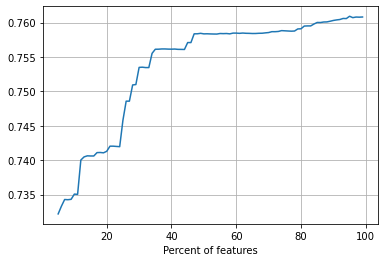

In [60]:
# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 

model = LogisticRegression(random_state=0)
cv_scores = []


for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_scaler_s, train_y)    
    cv_score = cross_val_score(model, X_new, train_y, scoring='roc_auc', cv=stf).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [61]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
selectp = SelectPercentile(percentile=best_score[0]).fit(train_scaler_s, train_y)
train_scaler_s = selectp.transform(train_scaler_s)
test_scaler_s = selectp.transform(test_scaler_s)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [62]:
train_scaler_s = pd.DataFrame(train_scaler_s)
test_scaler_s = pd.DataFrame(test_scaler_s)

train_scaler_s.shape

(45532, 95)

In [63]:
test_scaler_s.shape

(11383, 95)

**전처리 과정 결과 요약**

1. 성능을 기준으로 시간관련변수는 이상치 대체 적용 (raw feature, 로그변환 < 이상치 대체)    

2. 파생변수 생성
    마키아벨리즘 score
    TIPI
    교호작용
    
2. onehot encoding + PCA

3. Standard scaler

4. 95퍼센트 피쳐 선택

# 전처리 결과 데이터 저장

In [66]:
train_scaler_s.to_csv('best_train_scaler_s.csv',index=False,encoding='cp949')
test_scaler_s.to_csv('best_test_scaler_s.csv',index=False,encoding='cp949')
train_scaler_s.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0.727242,-0.861914,0.699521,-0.112770,0.934456,-0.126117,-0.117685,-0.232219,0.347458,2.099789,...,-1.553167,1.790931,1.041966,-0.209048,-1.169426,-0.119919,-0.730699,-0.241493,-0.262040,-0.069947
1,2.398171,-0.043598,1.338040,-0.183224,-0.462702,2.252766,2.254919,-0.962578,2.219359,0.616811,...,-0.322211,-0.053175,-0.342167,-0.931676,-0.029494,-2.898599,0.602494,-0.986137,0.189005,-0.566035
2,1.562707,2.303299,-1.216035,0.023193,-1.859859,-0.084260,2.254919,1.958857,-0.000670,-0.866167,...,-2.307851,0.126343,-0.372773,-0.154943,-0.765882,-0.063949,-0.588958,-0.129642,-0.092864,-0.279666
3,0.727242,-0.455638,0.061002,1.050332,0.235877,-0.134838,2.254919,-0.962578,-1.393182,-0.124678,...,-0.322211,-0.053175,-0.342167,-0.931676,-0.029494,-2.898599,0.602494,-0.986137,0.189005,-0.566035
4,-0.943687,0.763193,-1.216035,-0.932257,0.934456,-0.895243,-0.050652,-0.962578,-0.455805,-0.124678,...,-0.524211,1.030416,-0.107976,-0.088123,-1.533689,0.048434,-0.877576,-0.003506,-0.174438,-0.102792


# 모델링

## Train Test Split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train_scaler_m, train_y, test_size=0.3, random_state=0)

## 하이퍼파라미터 튜닝

## 베이지안 최적화

In [12]:
BO_tuned_clfs = []

### Logistic Regression

In [13]:
# 하이퍼 파라미터 범위

pbounds = { 'C': (0.0001,0.005),}


def logreg_opt(C):
    
    params = {
        'C' : C
    }

    logreg = LogisticRegression(**params, n_jobs=-1, random_state=0)

    score = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)


BO_lr = BayesianOptimization(f = logreg_opt, pbounds = pbounds, random_state=0)


In [14]:
BO_lr.maximize(init_points=15, n_iter=20)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7502   |  0.002789 |
|  2        |  0.7502   |  0.003604 |
|  3        |  0.7502   |  0.003054 |
|  4        |  0.7502   |  0.00277  |
|  5        |  0.7502   |  0.002176 |
|  6        |  0.7502   |  0.003265 |
|  7        |  0.7502   |  0.002244 |
|  8        |  0.7502   |  0.00447  |
|  9        |  0.7502   |  0.004822 |
|  10       |  0.7502   |  0.001979 |
|  11       |  0.7502   |  0.003979 |
|  12       |  0.7502   |  0.002692 |
|  13       |  0.7502   |  0.002883 |
|  14       |  0.7502   |  0.004635 |
|  15       |  0.7493   |  0.000448 |
|  16       |  0.7502   |  0.005    |
|  17       |  0.7502   |  0.004201 |
|  18       |  0.7502   |  0.003786 |
|  19       |  0.7502   |  0.002484 |
|  20       |  0.7502   |  0.003467 |
|  21       |  0.7502   |  0.004918 |
|  22       |  0.7502   |  0.003886 |
|  23       |  0.7502   |  0.003692 |
|  24       |  0.7502   |  0.004341 |
|  25       

In [15]:
BO_lr.max

{'target': 0.7502016094848868, 'params': {'C': 0.003737639055201483}}

In [16]:
max_params = BO_lr.max['params']
max_params

{'C': 0.003737639055201483}

In [17]:
lr_clf = LogisticRegression(**max_params,  n_jobs=-1, random_state=42)

scores = cross_val_score(lr_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((lr_clf.__class__.__name__, lr_clf, max(scores)))

[0.74823693 0.7376125  0.75660872 0.75940101]
최대성능: 0.7594010085581744
평균성능: 0.7504647882879723


### Random Forest

In [18]:
# 하이퍼 파라미터 범위

pbounds = { 'n_estimators': (130,180),
            'max_depth': (5,8),
            'max_features': (0.75,0.85),
            'min_samples_leaf': (3, 8)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    
    params = {
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'max_features' : max_features,        
        'min_samples_leaf' : int(round(min_samples_leaf))
    }

    rf = RandomForestClassifier(**params, n_jobs=-1, random_state=0)
    
    
    score = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)

In [19]:
BO_rf.maximize(init_points=15, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7621   |  6.646    |  0.8215   |  6.014    |  157.2    |
|  2        |  0.7621   |  6.271    |  0.8146   |  5.188    |  174.6    |
|  3        |  0.7622   |  7.891    |  0.7883   |  6.959    |  156.4    |
|  4        |  0.7619   |  6.704    |  0.8426   |  3.355    |  134.4    |
|  5        |  0.7615   |  5.061    |  0.8333   |  6.891    |  173.5    |
|  6        |  0.7622   |  7.936    |  0.8299   |  5.307    |  169.0    |
|  7        |  0.761    |  5.355    |  0.814    |  3.717    |  177.2    |
|  8        |  0.7623   |  6.566    |  0.7915   |  4.323    |  168.7    |
|  9        |  0.7621   |  6.368    |  0.8068   |  3.094    |  160.9    |
|  10       |  0.7623   |  6.836    |  0.8117   |  7.719    |  164.1    |
|  11       |  0.762    |  6.079    |  0.7937   |  6.488    |  133.0    |
|  12       |  0.7623   |  7.0      | 

In [23]:
# BO_rf.res  # 모든 성능 들어가있음
BO_rf.max

{'target': 0.7626969472482719,
 'params': {'max_depth': 7.965121514177678,
  'max_features': 0.7602044810748028,
  'min_samples_leaf': 4.044383780474174,
  'n_estimators': 138.0654758942498}}

In [24]:
max_params = BO_rf.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))

max_params

{'max_depth': 8,
 'max_features': 0.7602044810748028,
 'min_samples_leaf': 4,
 'n_estimators': 138}

In [25]:
rf_clf = RandomForestClassifier(**max_params,  n_jobs=-1, random_state=42)

scores = cross_val_score(rf_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((rf_clf.__class__.__name__, rf_clf, max(scores)))

[0.76274007 0.75353722 0.7673035  0.76764024]
최대성능: 0.7676402444131534
평균성능: 0.7628052562153168


### Extra Trees

In [27]:
pbounds = { 'n_estimators': (130, 180),
            'max_depth': (5,15),    
            'max_features': (0.7,0.9),
            'min_samples_split': (2, 5),
            'min_samples_leaf': (1, 5)
            }

def extra_opt(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):

    params = {
        'n_estimators': int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'max_features' : max_features,
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
    }
    
    extra = ExtraTreesClassifier(bootstrap = True, oob_score=True, **params, random_state=0, n_jobs=-1)

    score = cross_val_score(extra, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_extra = BayesianOptimization(f = extra_opt, pbounds = pbounds, random_state=0)    

In [28]:
BO_extra.maximize(init_points=15, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.7642   |  10.49    |  0.843    |  3.411    |  3.635    |  151.2    |
|  2        |  0.7644   |  11.46    |  0.7875   |  4.567    |  4.891    |  149.2    |
|  3        |  0.7631   |  12.92    |  0.8058   |  3.272    |  4.777    |  133.6    |
|  4        |  0.7612   |  5.871    |  0.704    |  4.33     |  4.334    |  173.5    |
|  5        |  0.7623   |  14.79    |  0.8598   |  2.846    |  4.342    |  135.9    |
|  6        |  0.7646   |  11.4     |  0.7287   |  4.779    |  3.566    |  150.7    |
|  7        |  0.7637   |  7.646    |  0.8548   |  2.825    |  3.705    |  130.9    |
|  8        |  0.7643   |  11.18    |  0.8224   |  3.468    |  4.831    |  164.1    |
|  9        |  0.7647   |  8.595    |  0.7874   |  3.791    |  2.181    |  163.3    |
|  10       |  0.7636   |  11.71    |  0.7421   |  1.5

In [30]:
BO_extra.max

{'target': 0.7646824322782558,
 'params': {'max_depth': 8.59507900573786,
  'max_features': 0.7874063907598683,
  'min_samples_leaf': 3.7905247837090594,
  'min_samples_split': 2.1806764148878095,
  'n_estimators': 163.3383357722834}}

In [31]:

# max_params = BO_extra.max['params']

# max_params['n_estimators'] = int(round(max_params['n_estimators']))
# max_params['max_depth'] = int(round(max_params['max_depth']))
# max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
# max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params = {'max_depth': 10,
 'max_features': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 162}
max_params

{'max_depth': 10,
 'max_features': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 162}

In [32]:
et_clf = ExtraTreesClassifier(**max_params,  n_jobs=-1, random_state=42)

scores = cross_val_score(et_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((et_clf.__class__.__name__, et_clf, max(scores)))


[0.76502429 0.75370733 0.77013738 0.76948513]
최대성능: 0.7701373776228246
평균성능: 0.7645885316459747


### Gradient Boosting

In [33]:
pbounds = { 'learning_rate': (0.01, 0.05),
            'n_estimators': (100, 200),
            'max_depth': (8,12),   
            'subsample': (0.75,0.85), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}


def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingClassifier(**params, random_state=0)
    
    score = cross_val_score(gbm, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)

In [ ]:
BO_gbm.maximize(init_points=10, n_iter=5)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.7564   |  0.03195  |  10.86    |  3.411    |  3.635    |  142.4    |  0.8146   |
|  2        |  0.7567   |  0.0275   |  11.57    |  4.855    |  3.15     |  179.2    |  0.8029   |
|  3        |  0.7541   |  0.03272  |  11.7     |  1.284    |  2.261    |  102.0    |  0.8333   |
|  4        |  0.7552   |  0.04113  |  11.48    |  4.914    |  4.397    |  146.1    |  0.8281   |
|  5        |  0.7581   |  0.01473  |  10.56    |  1.573    |  4.834    |  152.2    |  0.7915   |
|  6        |  0.7566   |  0.02058  |  11.1     |  2.825    |  3.705    |  101.9    |  0.8118   |
|  7        |  0.7581   |  0.03448  |  10.47    |  4.775    |  4.045    |  136.0    |  0.7937   |


In [67]:
BO_gbm.max

{'target': 0.7622105828025323,
 'params': {'learning_rate': 0.03423358873564129,
  'max_depth': 8.051607757729801,
  'min_samples_leaf': 3.4618959925899633,
  'min_samples_split': 3.238914315047091,
  'n_estimators': 199.17085774784988,
  'subsample': 0.7924275499598873}}

In [22]:
# max_params = BO_gbm.max['params']

# max_params['n_estimators'] = int(round(max_params['n_estimators']))
# max_params['max_depth'] = int(round(max_params['max_depth']))
# max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
# max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params = {'learning_rate': 0.03423358873564129,
 'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 199,
 'subsample': 0.7924275499598873}
max_params

{'learning_rate': 0.03423358873564129,
 'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 199,
 'subsample': 0.7924275499598873}

In [69]:
gbm_clf = GradientBoostingClassifier(**max_params, random_state=42)

scores = cross_val_score(gbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((gbm_clf.__class__.__name__, gbm_clf, max(scores)))

[0.7598641  0.74996102 0.76538815 0.76330898]
최대성능: 0.7653881501505562
평균성능: 0.7596305607716785


### XGBoost

In [70]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95),  
            'colsample': (0.7,0.9),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample,   
        'gamma': gamma,
        'n_jobs' : -1
    }
    
    xgb = XGBClassifier(**params)
    
    score = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [71]:
BO_xgb.maximize(init_points=5, n_iter=5)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.695    |  0.8098   |  3.576    |  0.924    |  6.814    |  134.7    |  0.8969   |
|  2        |  0.6736   |  0.7875   |  4.459    |  1.447    |  5.684    |  208.3    |  0.8793   |
|  3        |  0.765    |  0.8136   |  4.628    |  0.153    |  3.61     |  54.04    |  0.9249   |
|  4        |  0.6782   |  0.8556   |  4.35     |  1.469    |  8.594    |  142.3    |  0.9171   |
|  5        |  0.7364   |  0.7237   |  3.2      |  0.2579   |  9.613    |  154.4    |  0.8622   |
|  6        |  0.7386   |  0.8164   |  4.464    |  0.5718   |  4.366    |  60.04    |  0.9113   |
|  7        |  0.7013   |  0.7025   |  1.841    |  0.913    |  9.74     |  50.0     |  0.95     |
|  8        |  0.7646   |  0.8068   |  0.1309   |  0.2365   |  3.075    |  53.99    |  0.8317   |
|  9        |  0.757

In [72]:
BO_xgb.max

{'target': 0.7649696371860284,
 'params': {'colsample': 0.8136089122187864,
  'gamma': 4.627983191463305,
  'learning_rate': 0.15300228438693608,
  'max_depth': 3.6099050979107847,
  'n_estimators': 54.043679488065145,
  'subsample': 0.9248929768321906}}

In [24]:
# max_params = BO_xgb.max['params']

# max_params['n_estimators'] = int(round(max_params['n_estimators']))
# max_params['max_depth'] = int(round(max_params['max_depth']))

max_params = {'colsample': 0.8136089122187864,
 'gamma': 4.627983191463305,
 'learning_rate': 0.15300228438693608,
 'max_depth': 4,
 'n_estimators': 54,
 'subsample': 0.9248929768321906}


In [74]:
xgb_clf = XGBClassifier(**max_params)

scores = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((xgb_clf.__class__.__name__, xgb_clf, max(scores)))

[0.76573254 0.75588717 0.76792866 0.76815086]
최대성능: 0.7681508641136614
평균성능: 0.7644248058027975


### Light GBM

In [75]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMClassifier(**params)
    
    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)

In [76]:
BO_lgbm.maximize(init_points=15, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7527   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.7486   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.7465   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7581   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.7003   |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.7005   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.7238   |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [77]:
# BO_rf.res  # 모든 성능 들어가있음
BO_lgbm.max

{'target': 0.7661141650123466,
 'params': {'colsample_bytree': 0.75,
  'learning_rate': 0.05,
  'max_depth': 6.8134863145865845,
  'min_child_weight': 2.8174990799358777,
  'n_estimators': 112.74355995036092,
  'num_leaves': 10.0,
  'subsample': 0.95}}

In [78]:
max_params = BO_lgbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 2.8174990799358777,
 'n_estimators': 113,
 'num_leaves': 10,
 'subsample': 0.95}

In [79]:
lgbm_clf = LGBMClassifier(**max_params)

scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((lgbm_clf.__class__.__name__, lgbm_clf, max(scores)))

[0.76555874 0.75644848 0.77022406 0.76958669]
최대성능: 0.7702240602298481
평균성능: 0.7654544909071714


### MLP

In [ ]:
pbounds = { 'n_neighbors': (64,128,256),
            'alpha': (0.00001,0.0001),
            'batch_size': (128,256,512),   
            'learning_rate_init': (0.0001,0.001), 
            'max_iter': (100,200)}


def mlp_opt(hidden_layer_sizes,alpha,batch_size,learning_rate_init,max_iter):

    params = {
        'hidden_layer_sizes': int(round(hidden_layer_sizes)),
        'alpha' : alpha,
        'batch_size' : int(round(batch_size)),
        'learning_rate_init': learning_rate_init,
        'max_iter' : int(round(max_iter))
    }
    
    mlp = MLPClassifier(**params, n_jobs=-1)
    
    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_mlp = BayesianOptimization(f = mlp_opt, pbounds = pbounds, random_state=1)

In [76]:
BO_mlp.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7527   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.7486   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.7465   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7581   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.7003   |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.7005   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.7238   |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [77]:
# BO_rf.res  # 모든 성능 들어가있음
BO_mlp.max

{'target': 0.7661141650123466,
 'params': {'colsample_bytree': 0.75,
  'learning_rate': 0.05,
  'max_depth': 6.8134863145865845,
  'min_child_weight': 2.8174990799358777,
  'n_estimators': 112.74355995036092,
  'num_leaves': 10.0,
  'subsample': 0.95}}

In [78]:
max_params = BO_mlp.max['params']

max_params['hidden_layer_sizes'] = int(round(max_params['hidden_layer_sizes']))
max_params['alpha'] = max_params['alpha']
max_params['batch_size'] = int(round(max_params['batch_size']))
max_params['learning_rate_init'] = max_params['learning_rate_init']
max_params['max_iter'] = int(round(max_params['max_iter']))

max_params

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 2.8174990799358777,
 'n_estimators': 113,
 'num_leaves': 10,
 'subsample': 0.95}

In [79]:
mlp_clf = MLPClassifier(**max_params)

scores = cross_val_score(mlp_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((mlp_clf.__class__.__name__, lgbm_clf, max(scores)))

[0.76555874 0.75644848 0.77022406 0.76958669]
최대성능: 0.7702240602298481
평균성능: 0.7654544909071714


## Stacking

In [28]:
estimators = BO_tuned_clfs.copy()

In [29]:
stack_estimators = [estimators[i][1] for i in range(len(estimators))]

In [30]:
S_train, S_test = stacking(stack_estimators,
                           X_train, y_train, X_valid,
                           regression=False, needs_proba=True, metric=None, n_folds=4, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

[10:49:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:49:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:49:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bi

### LGBM meta-model

In [86]:
pbounds = { 'learning_rate': (0.01, 1.0),
            'n_estimators': (50, 200),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def meta_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    meta_model = LGBMClassifier(**params)
    
    score = cross_val_score(meta_model, S_train, y_train, scoring='roc_auc', cv=stf, n_jobs=-1)
    
    return np.mean(score)

BO_meta = BayesianOptimization(f = meta_opt, pbounds = pbounds, random_state=1)

In [87]:
BO_meta.maximize(init_points=20, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7618   |  0.8126   |  0.7231   |  3.001    |  2.814    |  72.01    |  2.739    |  0.8279   |
|  2        |  0.7615   |  0.8018   |  0.4028   |  6.772    |  3.515    |  152.8    |  3.636    |  0.9317   |
|  3        |  0.7615   |  0.7541   |  0.6738   |  5.921    |  4.352    |  71.06    |  3.585    |  0.9201   |
|  4        |  0.7639   |  0.8952   |  0.3203   |  7.846    |  6.258    |  184.2    |  2.68     |  0.8059   |
|  5        |  0.7354   |  0.7755   |  0.8794   |  3.688    |  3.527    |  193.7    |  6.265    |  0.9038   |
|  6        |  0.7348   |  0.7973   |  0.6896   |  8.842    |  1.11     |  162.5    |  9.911    |  0.9122   |
|  7        |  0.7496   |  0.7921   |  0.7914   |  3.723    |  3.687    |  186.3    |  4.349    |  0.8432   |
|  8      

In [88]:
BO_meta.max

{'target': 0.7666785146274535,
 'params': {'colsample_bytree': 0.7727640054522322,
  'learning_rate': 0.0794955809279899,
  'max_depth': 5.673769047966199,
  'min_child_weight': 6.894105756133415,
  'n_estimators': 66.2658356211557,
  'num_leaves': 5.039331936980245,
  'subsample': 0.9378347261144544}}

In [89]:
max_params = BO_meta.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.7727640054522322,
 'learning_rate': 0.0794955809279899,
 'max_depth': 6,
 'min_child_weight': 6.894105756133415,
 'n_estimators': 66,
 'num_leaves': 5,
 'subsample': 0.9378347261144544}

In [91]:
lgbm_clf = LGBMClassifier(**max_params)
lgbm_clf.fit(S_train,y_train)
roc_auc_score(y_valid, lgbm_clf.predict_proba(S_test)[:,1])

0.7709144885405377

In [93]:
### 전체 데이터 stacking 변환

train_stacking, test_stacking = stacking(stack_estimators,train_scaler_s, train_y, test_scaler_s,
                                         regression=False, needs_proba=True, metric=None, n_folds=4, stratified=True, shuffle=True,
                                         random_state=0, verbose=0)

[17:19:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bi

In [94]:
### meta model 전체 데이터에 재학습

lgbm_clf.fit(train_stacking,train_y)
l_pred = lgbm_clf.predict_proba(test_stacking)[:,1]

In [97]:
score = cross_val_score(lgbm_clf,train_stacking,train_y,cv=stf,scoring='roc_auc')
print(score)
print(score.mean())

[0.76622876 0.76580453 0.77182002 0.76989394 0.77500365]
0.7697501803292225


# submission

In [98]:
submission['voted'] = l_pred
submission.to_csv('best_submission.csv', index=False)
submission.head()

,index,voted
0,0,0.652207
1,1,0.896559
2,2,0.562978
3,3,0.325484
4,4,0.727334
